In [1]:
import networkx as nx
import matplotlib.pyplot as plt


from functions import *
from noisy_graphs import *
from sample_graphs import *
from frank_wolfe import *
from grampa import *

In [2]:
#G = nx.read_edgelist('./graphs/collaboration_astrophysics')
#A = nx.adjacency_matrix(G).todense()
#print("Number of nodes:", G.number_of_nodes())
#print("Number of edges:", G.number_of_edges())

In [3]:
#Gprime = nx.Graph.copy(G)
#B = nx.adjacency_matrix(Gprime)

# now run your algorithm on (G, Gprime) or on (A, B) !
#print("Number of nodes:", G.number_of_nodes())
#print("Number of edges:", G.number_of_edges())

In [4]:
# G and Gprime are too big (in memory) for computation
# new dataset

n = (50)
p = 0.4

A_eq, b_eq =  bistochastic_equality_constraints(n)

G0, A0 = sample_Erdos_Renyi(n, p) #same graphs ???
G1, A1 = sample_Erdos_Renyi(n, p)

Ps = rand_perm_matrix(n)


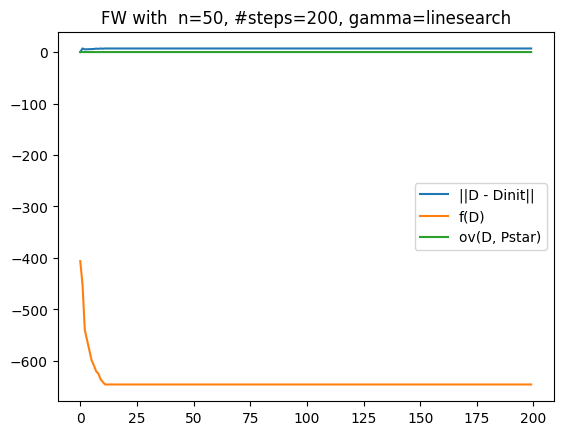

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
#Frank_wolfe algorithm

D = frank_wolfe(A0, A1, 200, Pstar=Ps , method="minustrace",plot=True)
print(D)
# minustrace more efficient than mindiff ??

32.09361307176243


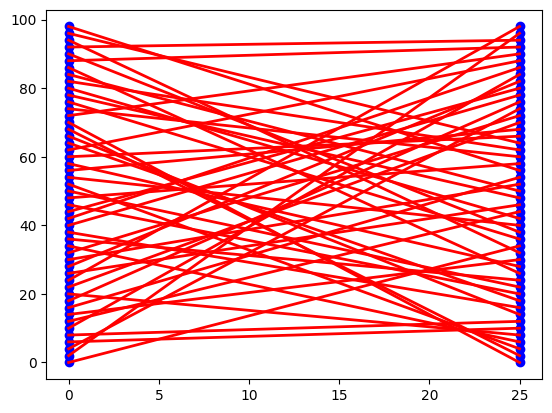

In [6]:
Dp = project_to_perm(D, A_eq, b_eq)

# we want to see how Dp appair these two graphs
plot_alignment(G0, G1, D)
print(np.linalg.norm(A0.toarray() - D * A1.toarray() * D.T))

32.09361307176243


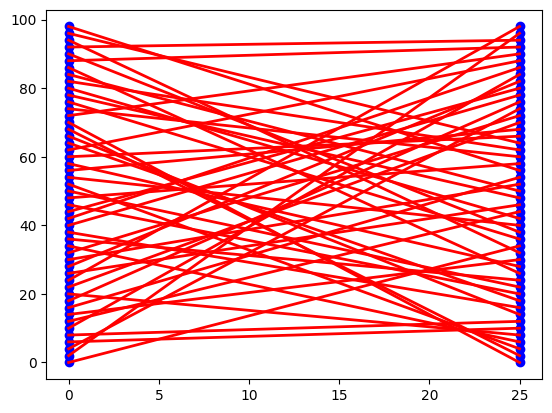

In [7]:
plot_alignment(G0,G1, Dp)
print(np.linalg.norm(A0.toarray() - Dp * A1.toarray() * Dp.T))

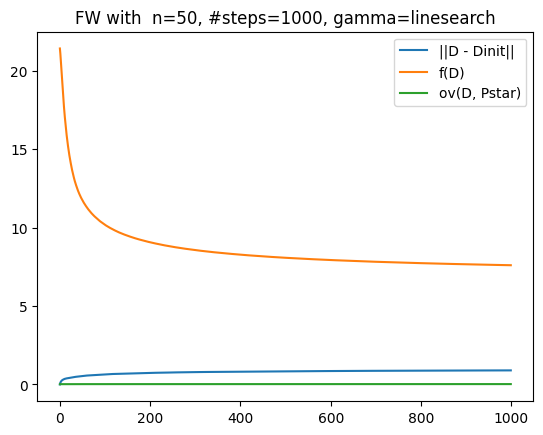

In [12]:
D1 = frank_wolfe(A0, A1, 1000, Pstar=Ps , method="mindiff",plot=True)


32.088213998274824


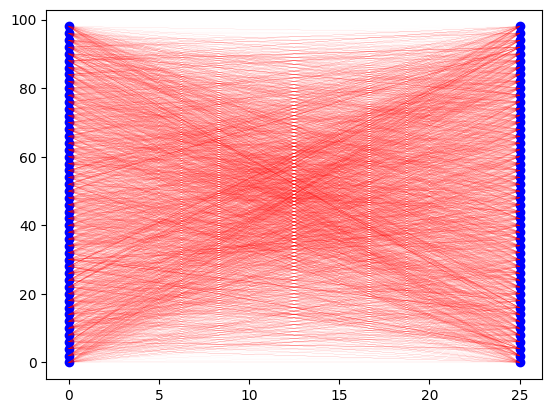

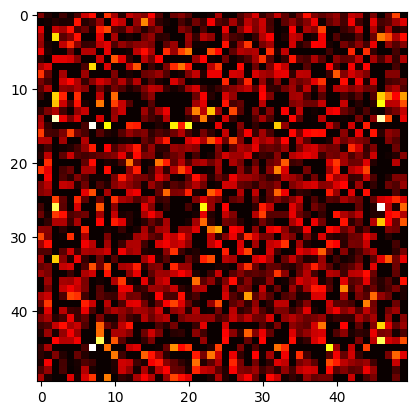

In [16]:
D1p = project_to_perm(D1, A_eq, b_eq)

# we want to see how Dp appair these two graphs
plot_alignment(G0, G1, D1)
print(np.linalg.norm(A0.toarray() - D1 * A1.toarray() * D1.T))
plt.show()
matrix_heatmap(D1)

32.09361307176243


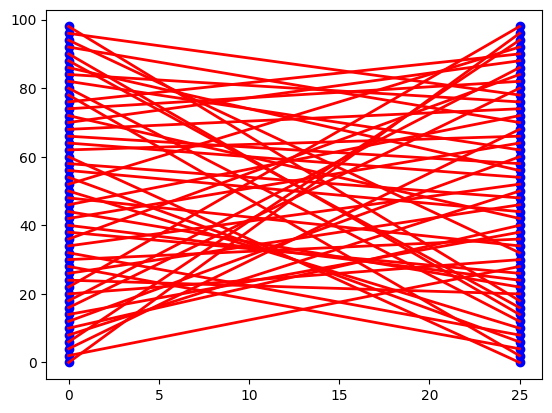

In [14]:
plot_alignment(G0, G1, D1p)
print(np.linalg.norm(A0.toarray() - D1p * A1.toarray() * D1p.T))

32.09361307176243


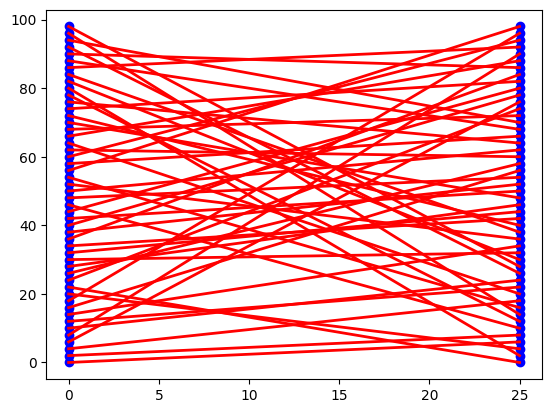

In [11]:
#GRAMPA ?

eta = 0.1
D2 = grampa(A0.toarray(), A1.toarray(), eta)
plot_alignment(G0, G1, D2)
print(np.linalg.norm(A0.toarray() - D2 * A1.toarray() * D2.T))